# Example of predicting sand thickness 
This example demonstrates how GeoST can be used to prepare data for predicting the
total thickness of sand within the first 4 meters below the surface based on boreholes
in the GDN database. The predictor will be trained on location (x/y coordinates), AHN 
elevation, geological map units and  geomorphological map units. For the prediction a 
gradient boost regressor algorithm will be employed, which is provided by the 
scikit-learn package.

Let's first import geost and other required packages:

In [1]:
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import (
    GradientBoostingRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import xarray as xr

import geost
from geost.spatial import find_area_labels, get_raster_values
from geost.utils import dataframe_to_geodataframe

Let's check the version of GeoST we're on:

In [2]:
print(geost.__version__)

0.2.4


These are the paths to the different data that we will use in this example:

In [3]:
resource_folder = Path.cwd() / 'resources'

study_area = resource_folder / 'study_area.shp'
gdn_data_file = resource_folder / 'GDN_borehole_data.parquet'
geological_map_file = resource_folder / 'BRO_geological_map.geoparquet'
geomorphological_map_file = resource_folder / 'BRO_geomorphological_map.geoparquet'
ahn_file = resource_folder / 'ahn.tif'


# Data preparation with GeoST
We will prepare the data first to make the appropriate selections, to add geological
and geommorphological map information to the boreholes and of course to get our training
target: the cumulative thickness of sand layers in the first 4 m.

In [4]:
gdn_data = geost.read_borehole_table(gdn_data_file)

print(gdn_data.n_points)

28628


gdn_data is a `BoreholeCollection` containing 28628 boreholes. We will first select 
boreholes within the study area using the method `select_within_polygons`. Our study
area shapefile contains one simple polygon, but more complex shapes and multiple
polygons are also supported.

In [5]:
gdn_data_selection = gdn_data.select_within_polygons(study_area)

print(gdn_data_selection.n_points)

20545


We now have 20545 boreholes left. Since we want to get the total thickness of sand 
within the first 4 m to train the model, we also need to select boreholes that are at 
least 4 m in length, because otherwise we will get an unwanted bias in our target data.
In addition we will cut off boreholes at 4 m, so all boreholes in the collection will be
exactly 4 m in length.

In [6]:
gdn_data_selection = gdn_data_selection.select_by_length(min_length=4)
gdn_data_selection = gdn_data_selection.slice_depth_interval(0, 4)

print(gdn_data_selection.n_points)

17574


This is our final filter, so we will be working with these 17574 boreholes. Next, we 
calculate the total thickness of sand within each borehole using the `get_cumulative_layer_thickness` method. 
These will be our target values to predict in the machine learning model!

In [7]:
# In the data column 'lith', calculate cumulative thickness of layers labelled 'Z' (sand)
# and include the results in the header table.
gdn_data_selection.get_cumulative_layer_thickness("lith", "Z", include_in_header=True)

The header table should now include a column called 'Z_thickness', let's check that:

In [8]:
gdn_data_selection.header[["nr", "Z_thickness"]]

,nr,Z_thickness
0,B38A0048,0.00
1,B38A0050,0.00
2,B38A0239,0.00
3,B38A0241,0.00
4,B38A0254,0.00
...,...,...
17569,B45A2789,1.42
17570,B45A2790,1.80
17571,B45A2792,0.30
17572,B45A2794,0.90


As we will use features from the geological and geomorphological map, we will now add
the geological and geomorphological areas in which our data points are located to the 
header dataframe using the built-in `get_area_labels` method:

In [9]:
# Read it like: from the geological map, get the value in the field "CODE" and add
# it to the header.
gdn_data_selection.get_area_labels(geological_map_file, "CODE", include_in_header=True)
gdn_data_selection.get_area_labels(
    geomorphological_map_file, "landformsubgroup_code", include_in_header=True
)

You can check that the columns "CODE" (geological map unit codes) and "landformsubgroup_code"
(geomorphological map unit codes) were added to each borehole in the header table:

In [10]:
gdn_data_selection.header[["nr", "CODE", "landformsubgroup_code"]]

,nr,CODE,landformsubgroup_code
0,B38A0048,kvo*,M81
1,B38A0050,kvo*,M81
2,B38A0239,kvo*,M81
3,B38A0241,kvo*,M81
4,B38A0254,kvo*,M81
...,...,...,...
17569,B45A2789,k,H43
17570,B45A2790,b,L42
17571,B45A2792,k,NaN
17572,B45A2794,k,NaN


# Applying the gradient boost regressor
We have now done all the neccessary preparation of our borehole data. Next we will
create dataframes for training features and the target values. One of the things we need 
to do for that is to apply one-hot encoding to the geological and geomorphological map
features. This will turn the unique strings into columns with 0 or 1 values, which is
required for most machine learning algorithms.

In [11]:
# Apply one-hot encoding
data_encoded_geology = pd.get_dummies(gdn_data_selection.header.gdf.loc[:, "CODE"])
data_encoded_morphology = pd.get_dummies(
    gdn_data_selection.header.gdf.loc[:, "landformsubgroup_code"]
)

# Extract features from the borehole header and join with one-hot encoded geological
# and geomorphological feature columns
features = gdn_data_selection.header[
    [
        "x",
        "y",
        "surface",
    ]
]
features = features.join(data_encoded_geology).join(data_encoded_morphology)

# Get target values from the borehole header (the Z_thickness column)
targets = gdn_data_selection.header["Z_thickness"]


# Split the features and targets into training and testing sets (80/20)
features_train, features_test, targets_train, targets_test = train_test_split(
    features,
    targets,
    test_size=0.2,
)

We will now create a gradient boost regressor and train it using our features_train and
targets_train

In [12]:
# Create the scikit-learn gradient boosting regressor with given hyperparameters
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    min_samples_split=4,
    min_samples_leaf=2,
    min_impurity_decrease=0.01,
    verbose=1,
    learning_rate=0.02,
    max_depth=10,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=10e-6,
)

# Fit the model using test features and targets (80% of the dataset)
gb_model.fit(features_train, targets_train)

# Predict sand thickness based on test features (20% of the dataset)
targets_predicted = gb_model.predict(features_test)

      Iter       Train Loss   Remaining Time 
         1           1.0112           28.82s
         2           0.9898           25.84s
         3           0.9694           24.38s
         4           0.9491           23.00s
         5           0.9300           21.88s
         6           0.9113           20.77s
         7           0.8932           21.20s
         8           0.8762           20.90s
         9           0.8598           20.37s
        10           0.8431           20.29s
        20           0.7074           18.09s
        30           0.6077           17.60s
        40           0.5318           16.62s
        50           0.4741           16.09s
        60           0.4272           15.47s
        70           0.3934           14.99s
        80           0.3652           14.25s
        90           0.3438           13.55s
       100           0.3258           12.80s


Let's see how it performed by checking the mean-square-error of the differences
between targets_predicted and targets_test:

In [13]:
mse = mean_squared_error(targets_test, targets_predicted)
print(mse)

0.5575679733450357


Some more advanced analysis of the model performance can be done by checking the mean
decrease in impurity. This is a decision-tree performance metric that indicates how
effective training features are at improving the predicted value when this feature is 
used to split a node into new leaves. You can essentially interpret the MDI as 'feature
importance'

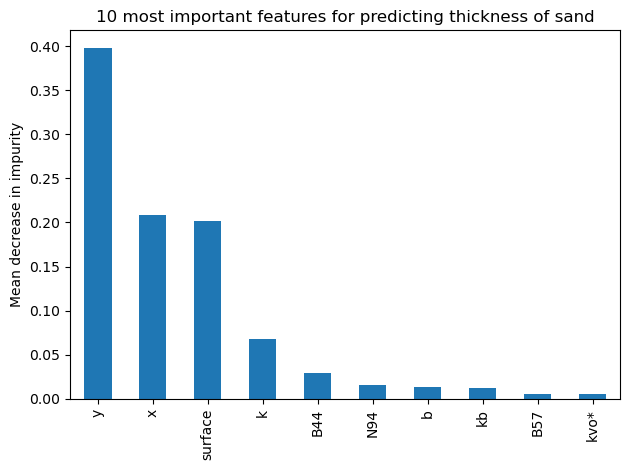

In [14]:
# Evaluate the model (Impurity decrease / feature importance) by plotting the MDI of the
# 10 most important features.
importance = pd.Series(gb_model.feature_importances_, index=features.columns)
fig, ax = plt.subplots()
importance.sort_values()[-10:][::-1].plot.bar(ax=ax)
ax.set_title("10 most important features for predicting thickness of sand")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

As you can see, the y-coordinate is the most important discriminator, followed by x and
surface height. The geological map unit 'k' (floodplain) is also important as it
typically indicates more clay/peat and less sand in the subsurface, whereas the
geomorphological unit 'B44' (channel belt) is indicative of more sand in the shallow
subsurface!

# Advanced use: making a map
The fitted model can be used to predict the thickness of sand for any combination of x-,
y-location, surface elevation and geological+geomorphological map units. In this more
advanced section we will create a regular grid of points for which we will run the
prediction using our previously fitted gradient boosting model and then turn the result
in a raster. We will also be using some (spatial) utility function of GeoST.

We will first define a grid and put all the query points in a pandas DataFrame:

In [15]:
# Grid data
xmin = 131000
xmax = 145000
ymin = 421000
ymax = 435000
resolution = 100

# x and y coordinate arrays
x_coors = np.arange(xmin, xmax, resolution)
y_coors = np.arange(ymin, ymax, resolution)

# Create array with all possible combinations of x and y coordinates and fit in a 
# pandas.DataFrame
query_points = np.array([(x, y) for x, y in product(x_coors, y_coors)])
query_points = pd.DataFrame(query_points, columns=("x", "y"))

We will now use some GeoST functions to sample the AHN elevation map at the query_points
(`geost.spatial.get_raster_values`)y, to turn a normal dataframe with columns containing 
coordinates into a geopandas Geodataframe containing geometries (`geost.utils.dataframe_to_geodataframe`)
and to assign geological and geomorphological map unit labels to the query_points (`geost.spatial.find_area_labels`).

In [16]:
# Use the get_raster_values function to sample from the AHN elevation map:
query_points["mv"] = get_raster_values(query_points["x"], query_points["y"], ahn_file)

# In order to add geological and geomorphological map units to the query_points
# dataframe we need to turn it into a geodataframe. Luckily we already have the x- and
# y-coordinates in the dataframe, so we can use the handy GeoST function
# 'dataframe_to_geodataframe' to do so and then use the find_area_labels function to add
# geological and geomorphological map unit labels.
query_points = dataframe_to_geodataframe(query_points, crs=28992)
query_points["CODE"] = find_area_labels(query_points, gpd.read_parquet(geological_map_file), "CODE")
query_points["landformsubgroup_code"] = find_area_labels(
    query_points, gpd.read_parquet(geomorphological_map_file), "landformsubgroup_code"
)

We will create two helper functions that we need to fill the grid of query points with
predicted values:

In [17]:
# Function to turn a string into the correct encoding
def string_to_encoded_array(row: pd.Series, column: str, encoding: pd.DataFrame):
    """
    Turn a string into encoding based on known one-hot encoding
    """
    string = row[column]
    result = [True if string == col else False for col in encoding]
    return result

# Function that can be applied to query points with feature data and returns predicted
# target values based a the given (fitted) scikit-learn machine learning model.
def model_predictions(
    ml_model,
    query_points,
    numerical_features: list = [],
    encoded_features: dict = {},
    min_allowed_value: int | float = 0,
    max_allowed_value: int | float = np.inf,
) -> np.ndarray:
    """
    Function to predict target values based on a scikit-learn trained ML-model at query
    points (e.g. a grid of points).

    Parameters
    ----------
    ml_model : sklearn.ensemble model
        scikit-learn fitted ensemble regressor model
    query_points : pd.DataFrame
        Pandas DataFrame with labelled columns for each feature that was used to train
        the ml_model on (and will thus be used for the predictions)
    numerical_features : list, optional
        List of numerical feature labels in query_points, by default []
    encoded_features : dict, optional
        Encoded feature labels in query points, mapped to the one-hot encoded dataframe
        for this feature, by default {}
    min_allowed_value : int | float, optional
        Minimum value to predict. If predicted value is lower it is forced to this
        min_allowed_value. By default 0.
    max_allowed_value : int | float, optional
        Maximum value to predict. If predicted value is higher it is forced to this
        max_allowed_value. By default np.inf

    Returns
    -------
    np.ndarray
        Numpy array with prediction results
    """
    predictions = []
    feature_labels = numerical_features

    for key, encodings in encoded_features.items():
        query_points[encodings.columns] = query_points.apply(
            string_to_encoded_array,
            args=(key, encodings.columns),
            axis=1,
            result_type="expand",
        )
        feature_labels += list(encodings.columns)

    predictions = ml_model.predict(query_points[feature_labels].values)
    predictions[predictions < min_allowed_value] = min_allowed_value
    predictions[predictions > max_allowed_value] = max_allowed_value

    return predictions

With the help of the `model_predictions` function, we will predict the total thickness
of sand using the fitted gradient boosting regressor for all query points.

In [18]:
query_points["predicted_z_thickness"] = model_predictions(
    gb_model,
    query_points,
    numerical_features=["x", "y", "mv"],
    encoded_features={
        "CODE": data_encoded_geology,
        "landformsubgroup_code": data_encoded_morphology,
    },
    min_allowed_value=0,
    max_allowed_value=4,
)

c:\Users\onselen\Development\sst-examples\.pixi\envs\default\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Next we reshape query_points to a 2D array and turn it into an Xarray.DataArray with
labelled coordinates

In [19]:
predicted_z_thickness_array = query_points["predicted_z_thickness"].values.reshape((len(x_coors), len(y_coors)))
predicted_z_thickness_da = xr.DataArray(predicted_z_thickness_array, 
                                        coords={"x": x_coors, "y": y_coors}
                                        ).transpose("y", "x")

Finally, let's visualize the results

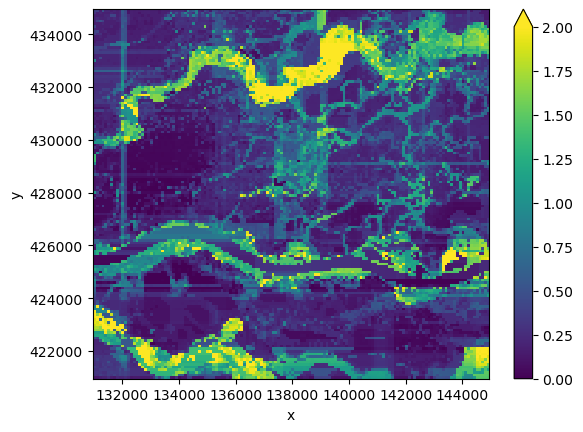

In [20]:
predicted_z_thickness_da.plot.imshow(vmin=0, vmax=2)
plt.show()

You can clearly see the relation between the predicted sand thickness and certain 
geological and geomorphological units!
